In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
# Initialize empty DataFrames
df_wl = pd.DataFrame()
df_non_wl = pd.DataFrame()

# Load data for wetland sites and add site codes
for site_number in range(2102, 2109):  # 2109 is not included, so it stops at 2108
    file_name = f"site_{site_number}_climate_data.csv"
    # Read the CSV file
    temp_df = pd.read_csv(file_name)
    # Add a new column for the site code, filled with the current site number for all rows in temp_df
    temp_df['site_code'] = site_number
    # Append to the main DataFrame
    df_wl = pd.concat([df_wl, temp_df], ignore_index=True)

# # Load data for non-wetland sites and add site codes
site_codes = ['BB', 'Bu', 'Cz', 'Gk', 'Gw', 'Hw', 'MD',"Mu"]
for site_code in site_codes:
    file_name = f"site_{site_code}_climate_data_TR.csv"
    temp2_df = pd.read_csv(file_name)
    # Add a new column for the site code, filled with the current site code for all rows in temp_df
    temp2_df['site_code'] = site_code
    # Append to the main DataFrame
    df_non_wl = pd.concat([df_non_wl, temp2_df], ignore_index=True)

# Load data for non-wetland sites and add site codes
file_name = f"combined_lincz_cmip6_data.csv"
temp2_df = pd.read_csv(file_name)
temp2_df['year1']=temp2_df["year"]
# Add a new column for the site code, filled with the current site code for all rows in temp_df
temp2_df['year'] = temp2_df["year1"].astype(str).str.slice(stop=4).astype(np.int64)+10

# Append to the main DataFrame
df_wl  = pd.concat([df_wl , temp2_df], ignore_index=True)
#df_wl.info()
print (f"{df_non_wl.shape}--{df_wl.shape}")


(5952, 7)--(5784, 11)


,location,year,month,tmin,tmax,prec,site_code,year_month,trange,type,year1
0,Cleveland Dam,1960,1,15.000000,26.000000,81.5,2102.0,NaN,NaN,NaN,NaN
1,Cleveland Dam,1960,2,15.000000,25.000000,166.9,2102.0,NaN,NaN,NaN,NaN
2,Cleveland Dam,1960,3,14.000000,25.000000,30.8,2102.0,NaN,NaN,NaN,NaN
3,Cleveland Dam,1960,4,12.000000,24.000000,96.3,2102.0,NaN,NaN,NaN,NaN
4,Cleveland Dam,1960,5,9.000000,22.000000,45.3,2102.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5779,Gwanda,2091,8,15.700000,33.099998,1.0,NaN,2081-2100-08,17.399999,SSP585,2081-2100
5780,Gwanda,2091,9,19.700001,37.099998,4.0,NaN,2081-2100-09,17.399998,SSP585,2081-2100
5781,Gwanda,2091,10,24.799999,40.000000,15.0,NaN,2081-2100-10,15.200001,SSP585,2081-2100
5782,Gwanda,2091,11,25.200001,39.799999,56.0,NaN,2081-2100-11,14.599998,SSP585,2081-2100


In [244]:
df_non_wl['Wetland']=0
df_non_wl["year_month"]=(df_non_wl['year']-min(df_non_wl['year']))*12+df_non_wl['month']
df_wl["Wetland"]=1
df_wl["year_month"]=(df_wl['year']-min(df_wl['year']))*12+df_wl['month']
df_org=pd.concat([df_non_wl,df_wl],ignore_index=False)
# df_org.head()
scaler=MinMaxScaler()
df_org["year_month_weight"]=scaler.fit_transform(df_org[["year_month"]])
df_org=df_org.drop(columns=["trange","site_code","year1","type"])
df_org.dropna(subset=["location","year","month","tmin","tmax","prec","year_month_weight"],inplace=True)
df_org

,location,year,month,tmin,tmax,prec,year_month,Wetland,year_month_weight
0,Beitbridge,1960,1,20.000000,34.000000,16.0,1,0,0.000000
1,Beitbridge,1960,2,21.000000,32.000000,65.1,2,0,0.000632
2,Beitbridge,1960,3,20.000000,33.000000,11.1,3,0,0.001263
3,Beitbridge,1960,4,16.000000,30.000000,31.1,4,0,0.001895
4,Beitbridge,1960,5,11.000000,28.000000,3.4,5,0,0.002527
...,...,...,...,...,...,...,...,...,...
5779,Gwanda,2091,8,15.700000,33.099998,1.0,1580,1,0.997473
5780,Gwanda,2091,9,19.700001,37.099998,4.0,1581,1,0.998105
5781,Gwanda,2091,10,24.799999,40.000000,15.0,1582,1,0.998737
5782,Gwanda,2091,11,25.200001,39.799999,56.0,1583,1,0.999368


Give the latest data higher weight as

In [245]:
X=df_org[["tmin","tmax","prec","year_month_weight"]]
y=df_org["Wetland"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
print (f"{X_train.shape}--{X_test.shape}--{y_train.shape}--{y_test.shape}")

(9388, 4)--(2348, 4)--(9388,)--(2348,)


In [246]:
def KNC_calculation(neighbors: int):
  score=[]
  correct=[]
  for i in range(10):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)
    y_pred=KNeighborsClassifier(n_neighbors=neighbors,weights='distance').fit(X_train,y_train).predict(X_test)
    score.append(accuracy_score(y_test,y_pred))
    correct.append((y_test==y_pred).sum())
  avgScore=pd.Series(score).mean()
  avgCorrect=pd.Series(correct).mean()
  return {"Neigbhours":neighbors,"AvgScore":avgScore,"AvgCorrect":avgCorrect}


Accuracy Score is around 60% -70%, it is not ideally, it may need some other factor to be fit in, such as wind etc.

> Add blockquote



   Neigbhours  AvgScore  AvgCorrect
0           1  0.631601      1483.0
1           3  0.649489      1525.0
2          10  0.658007      1545.0
3          20  0.660562      1551.0
4          40  0.657155      1543.0
5          50  0.666525      1565.0
6         100  0.667802      1568.0
7         200  0.663543      1558.0


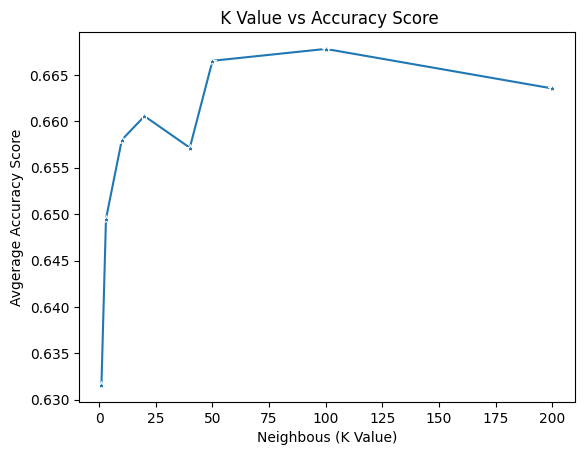

In [247]:
columns_types={"Neigbhours":int,"AvgScore":float,"AvgCorrect":float}
df_score=pd.DataFrame(columns=["Neigbhours","AvgScore","AvgCorrect"])
for neighbors in [1, 3, 10, 20, 40, 50,100,200]:
  df_score.loc[len(df_score)]=KNC_calculation(neighbors)
print (df_score)
# plotting
sns.lineplot(x=df_score["Neigbhours"],y=df_score["AvgScore"],marker="*")
plt.xlabel("Neighbous (K Value)")
plt.ylabel("Avgerage Accuracy Score")
plt.title(" K Value vs Accuracy Score")
plt.show()

0- Not Wetland
1 - Wetland
The confusion mix show the
* when the site is not wetland and predicted as wetland has lowest value
* when the site is not wetland and predicted as not wetland has highest value


Accuracy Score is 0.666098807495741


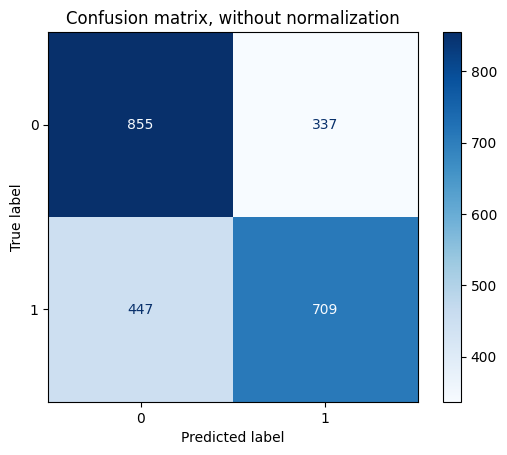

In [248]:
knn_clf=KNeighborsClassifier(n_neighbors=50,weights='distance')
knn_clf.fit(X_train,y_train)
y_pred=knn_clf.predict(X_test)
AccuracyScore=accuracy_score(y_test,y_pred)
print (f"Accuracy Score is {AccuracyScore}")
with plt.style.context("default"): #temporarily set the plot style
    disp = ConfusionMatrixDisplay.from_estimator(
        knn_clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=None,
    )
    disp.ax_.set_title("Confusion matrix, without normalization")